<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/0x02_PyTorch__multiclassModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000
    , n_features=NUM_FEATURES # X features
    , centers=NUM_CLASSES # y labels
    , cluster_std=1.5 # give the clusters a little shake up (try changing this to 1.0, the default)
    , random_state=RANDOM_SEED
)

In [4]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [5]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob
    , test_size=0.2
    , random_state=RANDOM_SEED
)

X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

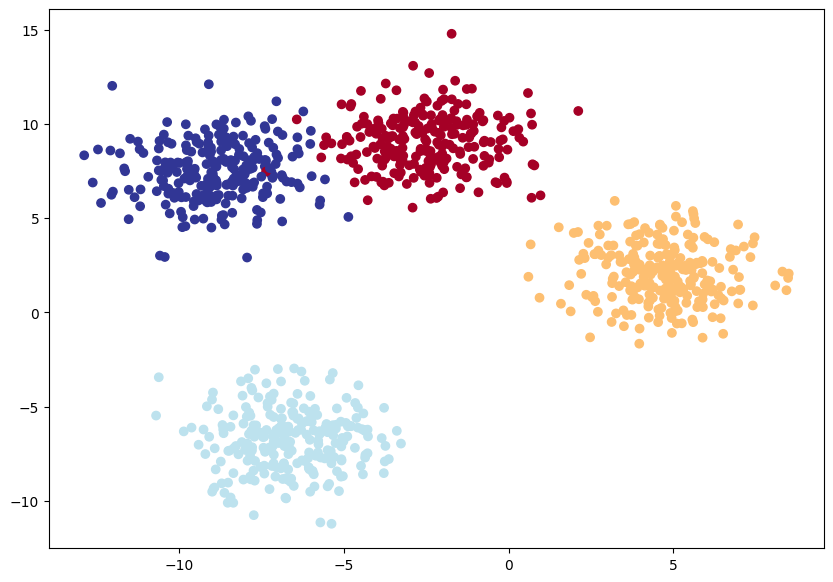

In [6]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(
    X_blob[:, 0], X_blob[:, 1]
    , c=y_blob, cmap=plt.cm.RdYlBu
    );

In [7]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units)
            , nn.ReLU() # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            , nn.Linear(in_features=hidden_units, out_features=hidden_units)
            , nn.ReLU() # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            , nn.Linear(in_features=hidden_units, out_features=output_features) # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [24]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(
    input_features=NUM_FEATURES
    , output_features=NUM_CLASSES
    , hidden_units=8
    ).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [25]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model_4.parameters()
    , lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [26]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [27]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [28]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [29]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [30]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


In [16]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [17]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [31]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(
        y_logits, dim=1
        ).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(
        y_true=y_blob_train
        , y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(
          y_true=y_blob_test
          , y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [32]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [33]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


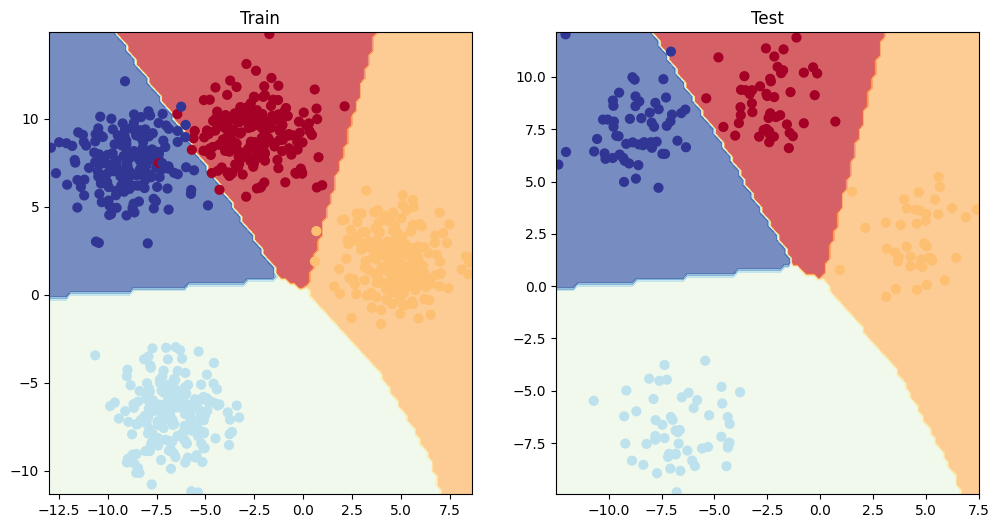

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)